In [257]:
%matplotlib inline
from multisim.multisim import *
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
import pfilter.pfilter as pf
from scipy.stats import norm
import seaborn as sns

In [258]:
# set up system
nsteps = 500

tfaulton  = 0.1
tfaultoff = 0.3
tend      = 3.0

time   = np.linspace(0,tend,nsteps)
step   = time[1]

time_1 = [t for t in time if t < tfaulton]
time_2 = [t for t in time if t > tfaulton and t < tfaultoff]
time_3 = [t for t in time if t > tfaultoff]


# We'll use these indexes to apply and remove the fault on the time loop
time_on_idx  = len(time_1)
time_off_idx = len(time_1) + len(time_2)


# create system: this can be a file that we parse
dsystem = System()
dsystem.silent()

for i in range(2):
    dsystem.addbus(i)

dsystem.buses[0].setvinit(cmath.rect(1.04, 0))
dsystem.buses[1].setvinit(cmath.rect(1.01613, (np.pi/180.0)*-3.3252))

dsystem.addbranch(0, 1, 0.0001, 0.0576)
dsystem.createYbusReal()

gen1 = GenGENROU(0, 1.575, 1.512, 0.29, 0.39, 0.1733, 0.0787, 3.38, 0.0, 6.09, 1.0, 0.05, 0.15)
gen1.setinitpow(1.06496, 0.45996)

load = ZLoad(1, (1.03123 + 1j*-0.37616))

dsystem.adddevice(gen1)

dsystem.addload(load)

In [259]:
#######################################
#######################################
##  FUNCTIONS FOR FILTERING         ###
##     2-axis generator             ###
#######################################
#######################################

# theta = [H xd eqp], u = [pm eqp]
# assume we have good grip on states
def prior(x, w, mean, prior_var):
    size = len(w)
    for i in range(size):
        x[0,i] = mean[0] #+ mean[0]*np.random.normal(0, prior_var)
        x[1,i] = mean[1] #+ mean[1]*np.random.normal(0, prior_var)
        x[2,i] = mean[2] #+ mean[2]*np.random.normal(0, prior_var)
        x[3,i] = mean[3] #+ mean[3]*np.random.normal(0, prior_var)

def measurement(theta, x, y, volt, meas_var):
    size = y.shape[1]
    for i in range(size):

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        delta = x[0, i]
        w     = x[1, i]
        eqp   = x[2, i]
        edp   = x[3, i]
        
        x_dp   = theta[2]
        x_qp   = theta[3]
        
        vd = vt*np.sin(delta - angle)
        vq = vt*np.cos(delta - angle)
        
        i_d = (eqp - vq)/x_dp
        i_q = (vd - edp)/x_qp
                
        y[0, i] = np.sin(delta)*i_d + np.cos(delta)*i_q  #+ np.random.normal(0, meas_var)
        y[1, i] = -np.cos(delta)*i_d + np.sin(delta)*i_q #+ np.random.normal(0, meas_var)

def likelihood(w, y, meas_curr, meas_var):
    size = y.shape[1]

    for i in range(size):
        w[i] = norm.pdf(y[0, i] - meas_curr[0], 0, meas_var)*norm.pdf(y[1, i] - meas_curr[1], 0, meas_var)

        
def propagate(theta, x, volt, h):
    
    size = x.shape[1]
    for i in range(size):
                
        x_d    = theta[0]
        x_q    = theta[1]
        x_dp   = theta[2]
        x_qp   = theta[3]
        H      = theta[4]
        T_d0p  = theta[5]
        T_q0p  = theta[6]
        e_fd   = theta[7]
        p_m    = theta[8]

        vt     = np.abs(volt[0] + 1j*volt[1])
        angle  = cmath.phase(volt[0] + 1j*volt[1])

        xold  = x[:, i]
        
        delta = xold[0]
        w     = xold[1]
        eqp   = xold[2]
        edp   = xold[3]

        v_d = vt*np.sin(delta - angle)
        v_q = vt*np.cos(delta - angle)
        
        i_d = (eqp - v_q)/x_dp
        i_q = (v_d - edp)/x_qp
                
        #print pm, vq*vd/xd - vd*(eqp - vq)/xd
        x[0, i] = x[0, i] + h*(2*np.pi*60.0*w)
        x[1, i] = x[1, i] + h*(p_m - v_q*i_q - v_d*i_d)/(2.0*H)
        x[2, i] = x[2, i] + h*(-eqp - (x_d - x_dp)*i_d + e_fd)/T_d0p
        x[3, i] = x[3, i] + h*(-edp + (x_q - x_qp)*i_q)/T_q0p
        
        x[0, i] = x[0, i]# + np.random.normal(0, 0.1)
        x[1, i] = x[1, i]# + np.random.normal(0, 0.001)
        x[2, i] = x[2, i]# + np.random.normal(0, 0.01)
        x[3, i] = x[3, i]# + np.random.normal(0, 0.01)

In [260]:
#######################################
#######################################
##  FUNCTIONS FOR CONTROL           ###
##                                  ###
#######################################
#######################################

def propagate_control(theta, x, u, volt, h):
    
    size = x.shape[1]
    for i in range(size):
                
        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = u[0, i]

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        xold = x[:, i]
        
        vd = vt*np.sin(xold[0] - angle)
        vq = vt*np.cos(xold[0] - angle)
                
        #print pm, vq*vd/xd - vd*(eqp - vq)/xd
        x[0, i] = x[0, i] + h*(2*np.pi*60.0*xold[1])  #+ np.random.normal(0, 0.01, 1)
        x[1, i] = x[1, i] + h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H) #+ np.random.normal(0, 0.001, 1)
        
def propagate_u(u, var):
    
    size = u.shape[1]
    for i in range(size):
        u[0, i] = u[0, i] + np.random.uniform(-var, var, 1)
        
def setpoint(x, s):
    
    size = x.shape[1]
    for i in range(size):
        s[0, i] = x[1, i] 
        
def weight_set(w, s, uk, setpoint, set_var):
    size = s.shape[1]
    for i in range(size):
        w[i] = w[i]*norm.pdf(s[0, i] - setpoint, 0, set_var)
        # LIMITS
        #if (uk[0, i] > 1.2):
        #    w[i] = 0    

In [261]:
# INITIALIZE SYSTEM AND PARTICLE FILTER
# Solve system
x = initialize_system(dsystem)

print x

# allocate array for trajectory plus steady-state solutions
trajectory = np.zeros((len(x), len(time)))
trajectory[:,0] = np.copy(x)

# initialize particle filter and priors
nparticles = 10
meas_noise = 3e-3
model_var = 0.01
meas_var  = 8e-2
prior_var = 0.1

# model parametes
theta = [gen1.x_d, gen1.x_q, gen1.x_dp, gen1.x_qp, gen1.H, gen1.T_d0p, gen1.T_q0p, gen1.e_fd, gen1.p_m]

# init cloud 
x_dim = 4
y_dim = 2
cl = pf.cloud(nparticles, x_dim, y_dim)
exp_n = np.zeros((x_dim, len(time)))

# prior sampling
meas_volt = x[dsystem.voltIdx(0):dsystem.voltIdx(0) + 2] #  + np.random.normal(0, meas_noise, 2)
meas_curr = [dsystem.devices[0].i_re, dsystem.devices[0].i_im] #   + np.random.normal(0, meas_noise, 2)


prior(cl.x, cl.w, [x[5], x[4], x[0], x[1]], prior_var = 0.1)


measurement(theta, cl.x, cl.y, meas_volt, meas_var)


likelihood(cl.w, cl.y, meas_curr, meas_var)
pf.normalize(cl.w)

exp_n[0, 0] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
exp_n[1, 0] = np.average(cl.x[1,:], axis = 0, weights=cl.w) 

[  1.06512037e+00   5.18199924e-01   8.50583832e-01  -6.61975001e-01
   2.54959845e-26   7.36183064e-01   7.70678363e-01   6.98322892e-01
   4.61853765e-01   1.01531728e+00   1.04000000e+00   0.00000000e+00
   1.01441925e+00  -5.89387053e-02]


In [262]:
# CREATE CONTROL PARTICLE FILTER

npart_mpc = 500
L = 20
mpc_pf = pf.cloud_control(npart_mpc, 2, 1, 1)

ptraj_x   = np.zeros((npart_mpc, L))
ptraj_exp = np.zeros(L)
ptraj_t   = np.zeros(L)

alpha = 0.5 # this is the prediction time step multiplier. 

u_history = []

In [263]:
for i in range(len(time) - 1):
    
    ############################
    ##### SIMULATION LOOP  #####
    ############################
    
    if (i == time_on_idx):
        fault_id = dsystem.applyBusFault(1, 0.1)
        x = solve_steady_system(trajectory[:, i], dsystem)
        
    elif (i == time_off_idx):
        dsystem.removeBusFault(fault_id)
        x = solve_steady_system(trajectory[:, i], dsystem)
        
    else:
        x = trajectory[:, i]
        
    trajectory[:, i + 1] = propagate_system(x, dsystem, step)
        
    # GENERATE MEASUREMENTS
    
    meas_volt = trajectory[dsystem.voltIdx(0):dsystem.voltIdx(0) + 2, i + 1] # + np.random.normal(0, meas_noise, 2)
    meas_curr = [dsystem.devices[0].i_re, dsystem.devices[0].i_im] #  + np.random.normal(0, meas_noise, 2)
    
    
    ############################
    ##### FILTERING LOOP   #####
    ############################
    #cl.pprint()
    cl.x = pf.resample_systematic(cl.w, cl.x)
    cl.w = (1.0/nparticles)*np.ones(nparticles)
    propagate(theta, cl.x, meas_volt, step)

    measurement(theta, cl.x, cl.y, meas_volt, 10*meas_var)
    likelihood(cl.w, cl.y, meas_curr, meas_var)
    pf.normalize(cl.w)
    exp_n[0, i + 1] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
    exp_n[1, i + 1] = np.average(cl.x[1,:], axis = 0, weights=cl.w) 
    
    ############################
    ##### CONTROL   LOOP   #####
    ############################
    
    if (0):
   
    # update states of particle cloud
        for j in range(npart_mpc):
            mpc_pf.x[:, j]  = trajectory[0:2, i + 1]
            mpc_pf.u[0, j]  = dsystem.devices[0].p_m + np.random.uniform(-0.2, 0.2, 1)
            mpc_pf.uk[0, j] = mpc_pf.u[0, j]
        
    # propagate for horizon
        for j in range(L):
            
            # Store predicted trajectories one point
            if (i == 40):
                ptraj_t[j] = time[i + 1] + alpha*j*step
                ptraj_x[:, j] = mpc_pf.x[1,:]
                ptraj_exp[j] = np.average(mpc_pf.x[1,:], axis = 0, weights=mpc_pf.w)
            
            mpc_pf.x, mpc_pf.u, mpc_pf.uk = pf.resample_systematic_control(mpc_pf.w, mpc_pf.x, 
                mpc_pf.u, mpc_pf.uk)
            mpc_pf.w = (1.0/npart_mpc)*np.ones(npart_mpc)
            
            propagate_control(theta, mpc_pf.x, mpc_pf.uk, meas_volt, alpha*step)
        
            setpoint(mpc_pf.x, mpc_pf.s)
            weight_set(mpc_pf.w, mpc_pf.s, mpc_pf.uk, 0.0, 0.01)
            pf.normalize(mpc_pf.w)
            propagate_u(mpc_pf.uk, 0.02)
            

                
        # calculate control
        u_set = np.average(mpc_pf.u[0,:], axis = 0, weights=mpc_pf.w)
        print "At time %g apply control %f" % (time[i], u_set)
    
        dsystem.devices[0].p_m = u_set
        u_history.append(u_set)

>>>APPLYING FAULT at bus: 1, z: 0.1.
Solve steady state
<<<REMOVING FAULT at bus: 1, z: 0.1.
Solve steady state


In [264]:
f, axes = plt.subplots(2, 1, figsize=(20, 21))

axes[0].plot(time, exp_n[0,:])
axes[0].plot(time, trajectory[5,:])
axes[1].plot(time[:], exp_n[1,:])
axes[1].plot(time[:], trajectory[4,:])

#axes[0].plot(time[:-1], exp_n[0,:-1])
#axes[0].plot(time, trajectory[0,:])
#axes[1].plot(time[40:60], exp_n[1,40:60])
#axes[1].plot(time[40:60], trajectory[1,40:60])

#axes[0].plot(exp_n[1,40:100])
#axes[0].plot(trajectory[1,41:101])


In [265]:
#print exp_n[0, :]
#cl.pprint()

In [266]:
plt.figure(figsize=[20,10])


for i in range(npart_mpc):
    plt.plot(ptraj_t, ptraj_x[i,:], color = "green", linestyle=':', linewidth=0.1)
plt.plot(ptraj_t, ptraj_exp, label = 'Expected', linewidth=1, linestyle = '--', color = [0,100/255,0])

#sns.tsplot(time = ptraj_t, data = ptraj_x, color="g", err_style = "ci_bars")
plt.plot(time, trajectory[1,:])
plt.axis([0, 0.5, -0.02, 0.06])

[0, 0.5, -0.02, 0.06]

In [267]:
plt.figure(figsize=(20,10))
plt.plot(time[:-1], np.abs(trajectory[6,:-1] + 1j*trajectory[7,:-1]))

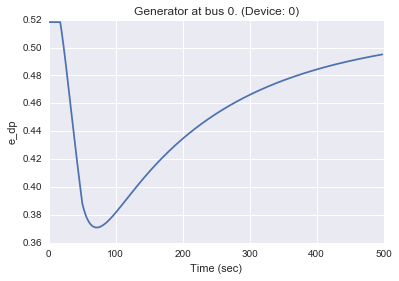

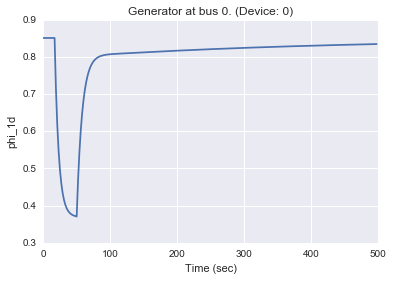

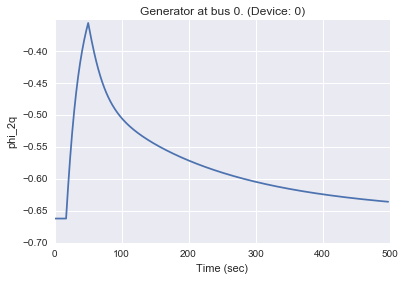

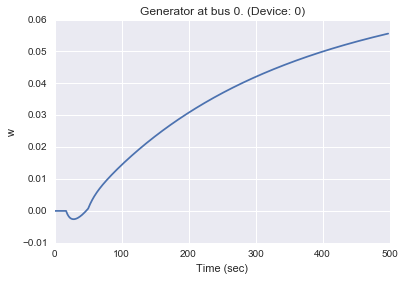

In [268]:
generator_plots(dsystem, trajectory[:,:-1], 0)